# Visualizing and Evaluating Forests of Uncertaint(r)ees
This notebook is a collection of visualizations and evaluation steps designed to help you better understand the approach and the results of our contribution to the 2023/24 ViEWS prediction challenge.


## General imports
General imports to be run before the individual cells. Make sure the working path is the src directory!

In [1]:
import os
from datetime import date
import pickle
import numpy as np
import pandas as pd
print(os.getcwd())

/home/daniel/views_competition_unibw_trees/src


## Clustering for local models
Below is a visualization of the different steps taken to generate clusters for our local models generated with the help of a version of our clustering function modified to be able to output intermediate steps.

return step 1
return step 2
return step 3


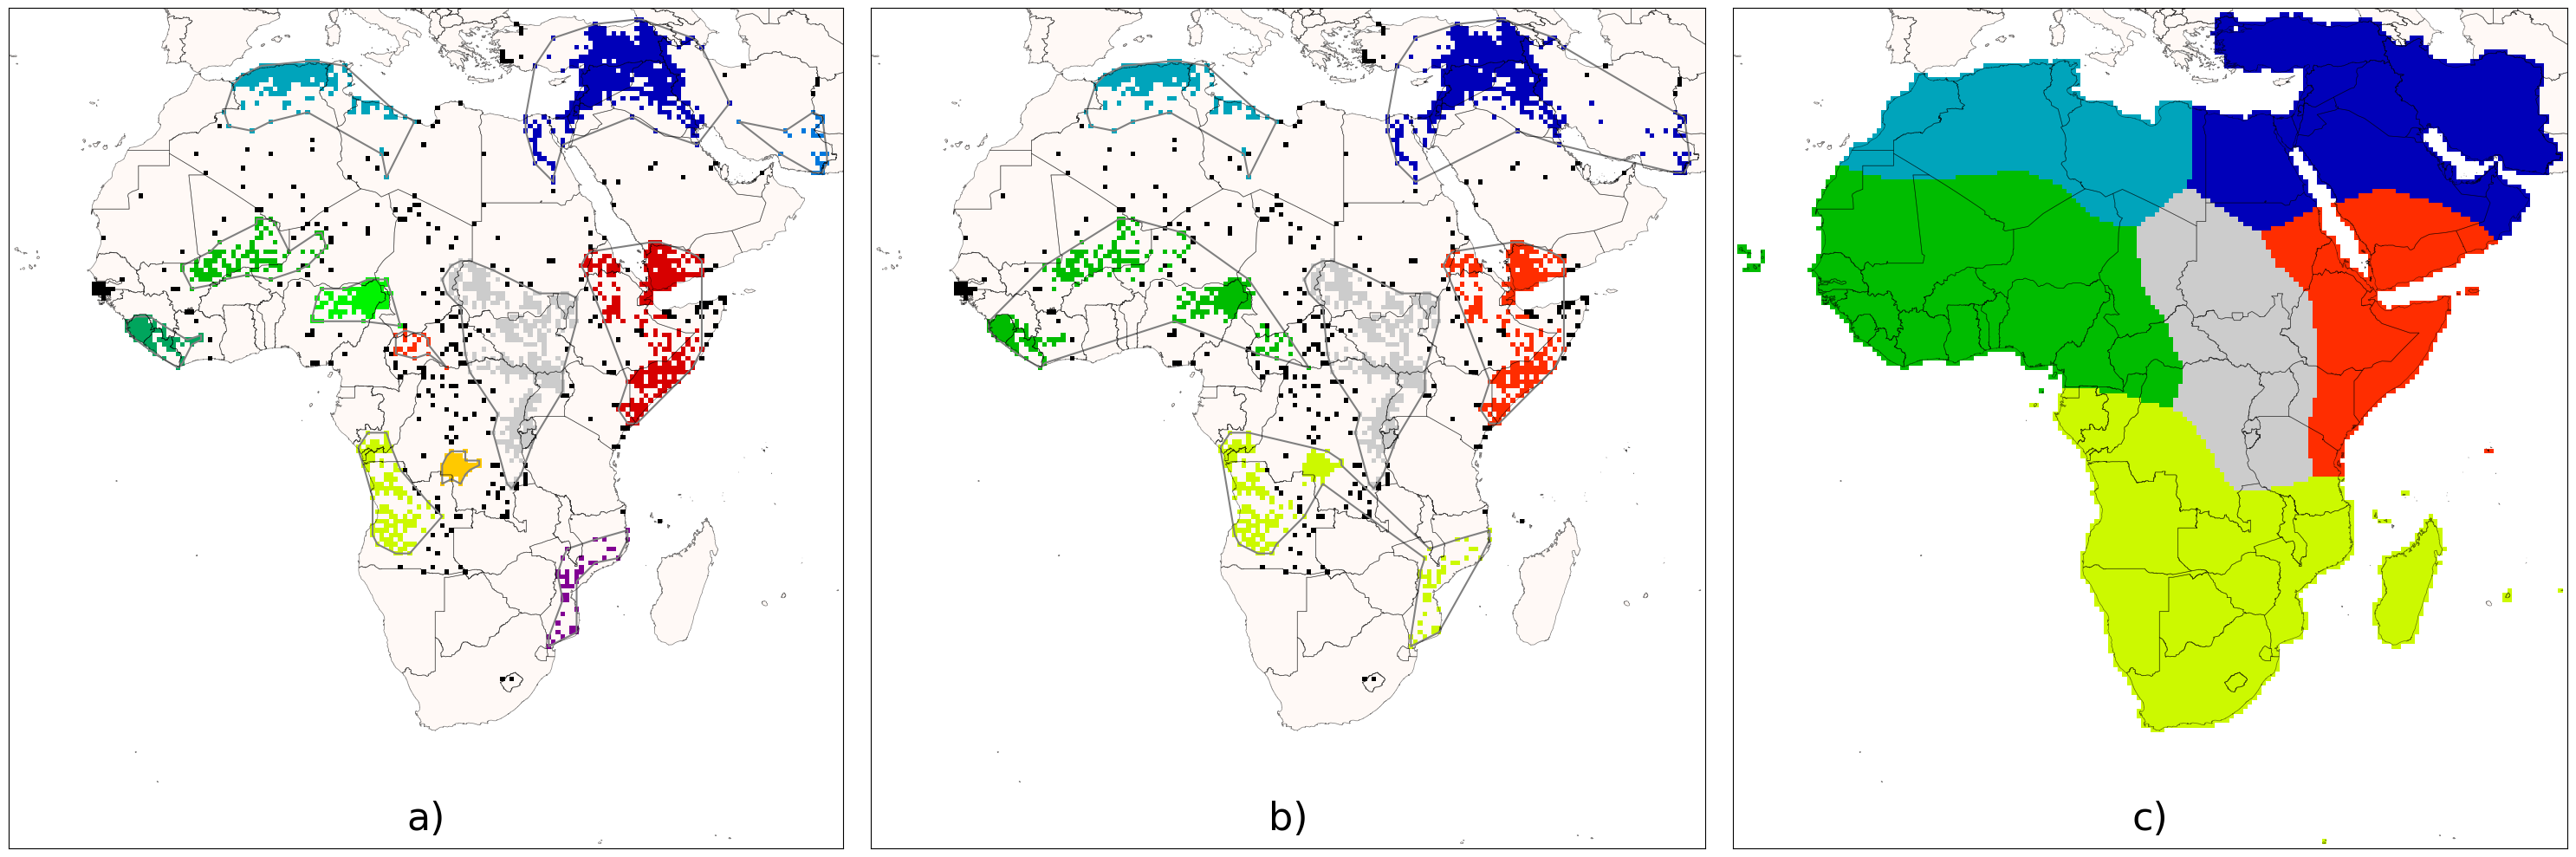

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN
from shapely import MultiPoint, Point, box
from shapely.constructive import concave_hull
from shapely.ops import nearest_points
from src.utils.conversion import get_month_id, pgid_to_latlon
from src.utils.data_prep import read_prio_training_data

# modified version of the clustering function to create steps in between
def make_clusters_hdbscan(df: pd.DataFrame, min_months: int, cluster_kwargs: dict,
                          visualize_clusters: bool = False, step:int =None) -> pd.DataFrame:
    """
    Semi-automated clustering with HDBSCAN based on spatial distribution of grid cells with violence across input data
    (disregarding time) and manually set parameters for the algorithm. Smaller clusters are merged with their nearest
    neighbors based on centroid distance if they do not include at least [min_months] grid months with violence. Grid
    cells without violence or not initially assigned are assigned based on the distance to polygons drawn around
    identified clusters.

    Args:
        df (pd.DataFrame): Dataframe with data used for clustering
        min_months (int): Minimum number of grid cell months to be included within a cluster to not be merged
        cluster_kwargs (dict): parameters for clustering algorithm
        visualize_clusters (bool): whether to also plot a graphic with the clusters

    Returns:
        pandas DataFrame with cluster assignments
    """
    def cluster_polys(ratio=0.5):
        polys = []
        ls = []
        for label in set(labels):
            # Skip noise clusters
            if label == -1:
                continue
            else:
                mask = labels == label  # Get all points belonging to the existing cluster
                # poly = MultiPoint(points[mask]).convex_hull
                polys.append(concave_hull(MultiPoint(points_violence[mask]), ratio=ratio))
                ls.append(label)
        gdf_polys = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), data=pd.Series(ls, name='index')).set_index('index')
        return gdf_polys

    def assign_zeros_to_clusters():
        # Now, create a distance matrix measuring the shortest distance of every point outside of the polygons
        # to the polygon borders.

        # Select all points that are not inside any cluster
        # That is basically all points with the target variable equal to 0 and all points with a label of -1
        coords = np.concatenate(
            (clust_df[clust_df['ged_sb'] == 0][['lon', 'lat']].to_numpy(), points_violence[labels == -1]))
        pgids = np.concatenate((clust_df[clust_df['ged_sb'] == 0].index.to_numpy(), pgids_violence[labels == -1]))
        for pgid, coord in zip(pgids, coords):
            point = Point(coord)
            min_distance = float('inf')  # Initialize with a very large value
            for cluster, poly in gdf_polys.geometry.items():
                nearest = nearest_points(poly.boundary, point)[0]  # Get the nearest point on the polygon's boundary
                distance = point.distance(nearest)  # Calculate the distance between the point and the nearest point
                if distance < min_distance:
                    min_distance = distance
                    clust_df.at[pgid, 'cluster'] = cluster
        return

    ## Identify pgids with fatalities and create clust_df
    clust_df = df.loc[:get_month_id(date(2017, 10, 31)), :].groupby('priogrid_gid')['ged_sb'].sum().to_frame()
    lat, lon = np.vectorize(pgid_to_latlon)(clust_df.index.to_list())
    clust_df = clust_df.assign(lat=lat, lon=lon)

    points_violence = clust_df[clust_df['ged_sb'] > 0][['lon', 'lat']].to_numpy()
    temp = (df.loc[:get_month_id(date(2017, 10, 31)), :]['ged_sb'] != 0).groupby('priogrid_gid').sum()
    weights = temp.loc[clust_df[clust_df['ged_sb'] > 0].index].values
    pgids_violence = clust_df[clust_df['ged_sb'] > 0].index.to_numpy()

    # manually tuned clusters for coverage of most visible cluster so there is something to assign to
    cluster = HDBSCAN(**cluster_kwargs).fit(points_violence)
    labels = cluster.labels_

    gdf_polys = cluster_polys()

    if step == 1:
        # setup lookup dict and add cluster info to clust_df
        cluster_assignments = dict.fromkeys(clust_df.index)
        for idx, label in enumerate(labels):
            cluster_assignments[pgids_violence[idx]] = label
        clust_df['cluster'] = pd.Series(cluster_assignments)
        print('return step', step)
        return clust_df, gdf_polys

    # calculate closest polygons for each based on centroids (this means smaller clusters are closer to each other)
    dist = []
    for poly in gdf_polys.geometry:
        distances = np.array(gdf_polys.centroid.distance(poly.centroid).sort_values().index[1:])
        dist.append(distances)
    gdf_polys['distances'] = dist

    # merge clusters which cover less than the specified minimum number of priogrid months to neighboring
    problem_groups = [c for c in np.unique(labels)[1:] if weights[labels == c].sum() < min_months]
    for c in problem_groups:
        mask = labels == c
        if weights[mask].sum() > min_months:
            continue
        labels[mask] = gdf_polys.loc[c].distances[0]

    # clean up clusters
    replace_map = {val: idx-1 for idx, val in enumerate(np.unique(labels))}
    labels = np.vectorize(lambda x: replace_map[x])(labels)

    # setup lookup dict and add cluster info to clust_df
    cluster_assignments = dict.fromkeys(clust_df.index)
    for idx, label in enumerate(labels):
        cluster_assignments[pgids_violence[idx]] = label
    clust_df['cluster'] = pd.Series(cluster_assignments)

    # re-calculate polygons based on merged clusters before assigning non-assigned grids
    gdf_polys = cluster_polys()
    if step == 2 :
        print('return step', step)
        return clust_df, gdf_polys

    assign_zeros_to_clusters()

    clust_df['cluster'] = clust_df['cluster'].astype(int)

    if step == 3:
        print('return step', step)
        return clust_df, gdf_polys

    return clust_df

fp_views = '../views_data/' # path to views data
df_train, _ = read_prio_training_data(fp_views)
min_months = 1000
cluster_kwargs = {'min_cluster_size': 18, 'min_samples': 15, 'cluster_selection_epsilon': 2.2}

# generate the different steps in between
clust_df1, gdf_polys1 = make_clusters_hdbscan(df_train, min_months, cluster_kwargs, step=1)
clust_df2, gdf_polys2 = make_clusters_hdbscan(df_train, min_months, cluster_kwargs, step=2)
clust_df3, gdf_polys3 = make_clusters_hdbscan(df_train, min_months, cluster_kwargs, step=3)

# plotting
countries = gpd.read_file('data/geoBoundariesCGAZ_ADM0.gpkg', crs='4326')
clust_gdf3 = clust_df3.copy()
clust_gdf3['coords'] = list(clust_gdf3.reset_index().priogrid_gid.apply(pgid_to_latlon))
clust_gdf3['geometry'] = clust_gdf3.coords.apply(lambda x: box(x[1] - .25, x[0] - .25, x[1] + .25, x[0] + .25))
clust_gdf3 = gpd.GeoDataFrame(clust_gdf3, geometry=clust_gdf3.geometry)
views_bounds = clust_gdf3.total_bounds

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for ax in axs:
    countries.plot(facecolor='seashell', edgecolor='None', ax=ax, linewidth=0.5, alpha=0.5)

clust_df1.set_index(['lat', 'lon'])['cluster'].to_xarray().plot(ax=axs[0], cmap='nipy_spectral',
                                                               vmin=clust_df1['cluster'].min(),
                                                               vmax=clust_df1['cluster'].max(),
                                                               add_colorbar=False, add_labels=False)
gdf_polys1.plot(ax=axs[0], facecolor='None', edgecolor='gray', linewidth=1.5)

clust_df2.set_index(['lat', 'lon'])['cluster'].to_xarray().plot(ax=axs[1], cmap='nipy_spectral',
                                                                vmin=clust_df2['cluster'].min(),
                                                                vmax=clust_df2['cluster'].max(),
                                                                add_colorbar=False, add_labels=False)

gdf_polys2.plot(ax=axs[1], facecolor='None', edgecolor='gray', linewidth=1.5)

clust_gdf3.plot(column='cluster', ax=axs[2], cmap='nipy_spectral', vmin=clust_df2['cluster'].min(), 
                vmax=clust_df2['cluster'].max(), legend=False)

for i, ax in enumerate(axs):
    countries.plot(facecolor='None', edgecolor='black', ax=ax, linewidth=0.5, alpha=0.5)
    ax.set_xlim(views_bounds[0]-.5, views_bounds[2]+.5)
    ax.set_ylim(views_bounds[1]-.5, views_bounds[3]+.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f'{chr(97+i)})', size=32, labelpad=-40)
plt.tight_layout()
plt.savefig('figures/Figure_1_local_clustering.png', dpi=300)
plt.show()

## Model selection

Setup for reading which model was selected: The HurdleStepsWithTuning class can output the best tuned model but wasn't setup to only read the data, so tuning config is required. Below is the copy-pasted tuning config, which consists mainly of the hyperparameter spaces, for our tuning and prediction pipeline.

In [4]:
from functools import partial
from hyperopt import hp
from sklearn.metrics import make_scorer, average_precision_score
from src.utils.scoring import drf_predict, qrf_predict, ngb_predict, crps_scorer

# these wrappers handle custom kwargs/options for predictors to get consistent output
prediction_wrappers = {
    'DRF': drf_predict,
    'QRF': qrf_predict,
    'NGB': ngb_predict,
}

# we use precision recall by default for classifier tuning
scorer_clf = {
    'RF': make_scorer(average_precision_score, response_method='predict_proba'),
    'XGB': make_scorer(average_precision_score, response_method='predict_proba'),
}

# freeze the estimator-specific prediction function in the general scorer function
scorer_reg = {key: partial(crps_scorer, func=item) for key, item in prediction_wrappers.items()}

# implementation is based on this structure (model_type: {space: {}, max_evals: int})
tuning_space_clf = {
    'RF': {
        'space': {
            'max_depth': hp.uniformint(label='max_depth', low=3, high=8),
            'n_estimators': hp.quniform(label='n_estimators', low=40, high=1000, q=20)
        },
        'max_evals': 30
    },
    'XGB': {
        'space': {
            'max_depth': hp.uniformint(label='max_depth', low=3, high=20, q=1),
            'n_estimators': hp.uniformint(label='n_estimators', low=40, high=1001, q=50),
            'learning_rate': hp.choice(label='learning_rate', options=[.001, .005, .01, .05, .1, .3]),  # important
            'gamma': hp.uniform(label='gamma', low=1, high=9),  # less important
            'subsample': hp.quniform(label='subsample', low=0.5, high=1.0, q=0.1),
            'colsample_bytree': hp.quniform(label='colsample_bytree', low=0.5, high=1, q=0.1),  # less important
            'reg_alpha': hp.uniformint(label='reg_alpha', low=0, high=100, q=1),  # less important
            'reg_lambda': hp.uniform(label='reg_lambda', low=0, high=1),  # less important
            'min_child_weight': hp.loguniform(label='min_child_weight', low=-3, high=2.75),  # important
            'max_delta_step': hp.uniform(label='max_delta_step', low=1, high=10)
        },
        'max_evals': 100
    },
}

tuning_space_reg = {
    'DRF': {
        'space': {
            'num_features': hp.uniformint(label='num_features', low=5, high=50, q=1),
            'num_trees': hp.quniform(label='num_trees', low=40, high=1000, q=20),
            'min_node_size': hp.uniformint(label='min_node_size', low=5, high=20, q=1),
            'alpha': hp.quniform(label='alpha', low=.01, high=.2, q=.01),  # less important
        },
        'max_evals': 50
    },
    'QRF': {
        'space': {
            'n_estimators': hp.quniform(label='n_estimators', low=160, high=1000, q=20), # fairly important
            'max_depth': hp.uniformint(label='max_depth', low=3, high=6), # important
            'criterion': hp.choice(label='criterion', options=['absolute_error']), # apparently not as good: ['squared_error', 'friedman_mse', 'poisson']
            'min_samples_split': hp.uniformint(label='min_samples_split', low=5, high=20, q=1), # less important
            'min_samples_leaf': hp.uniformint(label='min_samples_leaf', low=10, high=40, q=1),
            'max_features': hp.choice(label='max_features', options=['log2']), # ['sqrt', None] seem worse
        },
        'max_evals': 50
    },
    'NGB': {
        'space': {
            'n_estimators': hp.quniform(label='n_estimators', low=200, high=500, q=20),
            'learning_rate': hp.choice(label='learning_rate', options=[.001, .005, .01]),
            'base_criterion': hp.choice(label='base_criterion', options=['squared_error', 'friedman_mse']), # not important, both better than 'absolute_error'
            'base_splitter': hp.choice(label='base_splitter', options=['random']), # 'random' apparently better than 'best'
            'base_max_depth': hp.uniformint(label='base_max_depth', low=2, high=4),
            'minibatch_frac': hp.quniform(label='minibatch_frac', low=0.1, high=1, q=.1),
            'col_sample': hp.quniform(label='col_sample', low=0.1, high=1, q=.1),
        },
        'max_evals': 50
    },
}

hurdle_kwargs = {
    'scorer_clf': scorer_clf,
    'scorer_reg': scorer_reg,
    'tuning_space_clf': tuning_space_clf,
    'tuning_space_reg': tuning_space_reg,
    'prediction_wrappers': prediction_wrappers,
}

Automatic model selection - which models are selected for which step based on tuning performance? Loads selections from existing tuning results.

In [ ]:
from tqdm import tqdm
from src.estimators.hurdle import HurdleStepsWithTuning
from src.utils.data_prep import read_prio_training_data

fp_tuning = 'tuning_trials_hdbscan/'
fp_views = '../views_data'

def create_model_selection_df(fp_views:str, clusters:str, hurdle_kwargs:dict):
    df_train, model_dict = read_prio_training_data(fp_views)
    with open('data/clusters_dict.pkl', 'rb') as f:
        df_clusters = pickle.load(f)[clusters]
    targets = model_dict['targets_reg']
    features = model_dict['features']
    timesteps = [t[t.rfind('_') + 1:] for t in targets]
    cluster_list = sorted(df_clusters.cluster.unique())
    index = pd.MultiIndex.from_product([timesteps, ['global']+cluster_list], names=['timestep', 'cluster'])
    df_model_selection = pd.DataFrame(index=index, columns=['classification', 'regression'])
    for t in tqdm(targets):
        timestep = t[t.rfind('_') + 1:]
        global_hurdle = HurdleStepsWithTuning(**hurdle_kwargs, fp_tuning=fp_tuning)
        global_hurdle.tune(df_train, features=features, target=t)
        df_model_selection.loc[(timestep, 'global'), 'classification'] = global_hurdle.clf_model_type
        df_model_selection.loc[(timestep, 'global'), 'regression'] = global_hurdle.reg_model_type
        for c in cluster_list:
            local_hurdle = HurdleStepsWithTuning(**hurdle_kwargs, fp_tuning=fp_tuning)
            local_hurdle.tune(df_train, features=features, target=t, local_model=True, cluster=c)
            df_model_selection.loc[(timestep, c), 'classification'] = local_hurdle.clf_model_type
            df_model_selection.loc[(timestep, c), 'regression'] = local_hurdle.reg_model_type
    return df_model_selection

df_model_selection = create_model_selection_df(fp_views, 'hdbscan', hurdle_kwargs);
# This cell prints way too much for jupyter...

In [6]:
df_model_selection

classification regression
timestep cluster                          
t3       global              RF        QRF
         0                   RF        NGB
         1                  XGB        NGB
         2                  XGB        NGB
         3                  XGB        NGB
...                         ...        ...
t14      1                  XGB        NGB
         2                  XGB        NGB
         3                  XGB        NGB
         4                  XGB        QRF
         5                  XGB        NGB

[84 rows x 2 columns]

## Model Evaluation
How does the performance of our three main models compare to the benchmarks for the test windows based on various metrics? 
This simply loads the pre-generated metrics, see `src/evaluation_pipeline.py` for how they are generated.

In [7]:
from src.utils.data_prep import read_prio_actuals

fp_views = '../views_data/'
fp_metrics = f'evaluation/metrics'
test_windows = [2018, 2019, 2020, 2021, 2022, 2023] # we can of course only evaluate up to 2023

dfs = []
df_stats = pd.DataFrame(index=pd.Index(test_windows, name='window'), columns=['mean_fat', 'dummy_count'])
for year in test_windows:
    # Trends in metrics correlate with mean fatalities/number of
    actuals = read_prio_actuals(fp_views, year, as_xarray=False)
    df_stats.at[year, 'mean_fat'] = actuals.ged_sb.mean()
    df_stats.at[year, 'dummy_count'] = (actuals.ged_sb > 0).sum()
    fp_metrics_window = os.path.join(fp_metrics, f'metrics_benchmarks_full_{year}.csv')
    df = pd.read_csv(fp_metrics_window, index_col=0)
    df['window'] = year
    dfs.append(df.set_index('window', append=True))

print(df_stats)
df_metrics = pd.concat(dfs)
df_metrics


        mean_fat dummy_count
window                      
2018    0.144413        1220
2019    0.115446        1264
2020    0.131871        1473
2021    0.939804        1649
2022    1.137471        1666
2023    0.223614        1683


,,global,local,global-local,conflictology_n,last,zero,conflictology,boot_240
metrics,window,,,,,,,,
crps,2018,0.130027,0.137576,0.132371,0.147324,3.860120e-01,0.144413,0.191881,0.144348
ign,2018,0.056806,0.068819,0.057642,0.155875,1.001305e-01,0.076333,0.788673,0.077012
mis,2018,3.440646,4.484046,3.556302,5.275473,1.387923e+01,5.776506,4.642180,5.776506
mse,2018,60.553773,56.311885,62.147443,69.366597,1.698174e+02,65.815338,91.442317,67.003096
mae,2018,0.310588,0.489196,0.337899,0.365121,4.048091e-01,0.144413,0.350955,0.310791
crps,2019,0.100957,0.103962,0.101202,0.106776,1.441701e-01,0.115446,0.118448,0.115406
ign,2019,0.054957,0.066793,0.055239,0.153899,8.697741e-02,0.077664,0.786013,0.078329
mis,2019,2.562925,3.578303,2.651482,3.255669,5.039398e+00,4.617849,3.125886,4.617849
mse,2019,17.805989,16.914514,22.291566,18.191376,1.823658e+01,17.238787,32.223404,18.498602


Quick look at score correlations...

In [8]:
dfs = []
for metric in ['crps', 'ign', 'mis', 'mse', 'mae']:
    df = df_stats.copy()
    for col in df_metrics.columns:
        df[col] = df_metrics.loc[metric][col]
    df['metric'] = metric
    df = df.set_index('metric', append=True)
    dfs.append(df)
df_cor = pd.concat(dfs, axis=0)

In [9]:
df_cor.loc[:, 'crps', :].corr()

,mean_fat,dummy_count,global,local,global-local,conflictology_n,last,zero,conflictology,boot_240
mean_fat,1.000000,0.660245,0.999984,0.999978,0.999974,0.999566,-0.107294,1.000000,0.965318,1.000000
dummy_count,0.660245,1.000000,0.662974,0.663166,0.663651,0.674148,0.540453,0.660245,0.784142,0.660163
global,0.999984,0.662974,1.000000,0.999992,0.999997,0.999688,-0.102684,0.999984,0.966511,0.999984
local,0.999978,0.663166,0.999992,1.000000,0.999997,0.999734,-0.101590,0.999978,0.966883,0.999978
global-local,0.999974,0.663651,0.999997,0.999997,1.000000,0.999743,-0.100851,0.999974,0.967033,0.999974
conflictology_n,0.999566,0.674148,0.999688,0.999734,0.999743,1.000000,-0.079556,0.999566,0.972435,0.999564
last,-0.107294,0.540453,-0.102684,-0.101590,-0.100851,-0.079556,1.000000,-0.107294,0.153538,-0.107371
zero,1.000000,0.660245,0.999984,0.999978,0.999974,0.999566,-0.107294,1.000000,0.965318,1.000000
conflictology,0.965318,0.784142,0.966511,0.966883,0.967033,0.972435,0.153538,0.965318,1.000000,0.965300
boot_240,1.000000,0.660163,0.999984,0.999978,0.999974,0.999564,-0.107371,1.000000,0.965300,1.000000


... and making it visible as well.

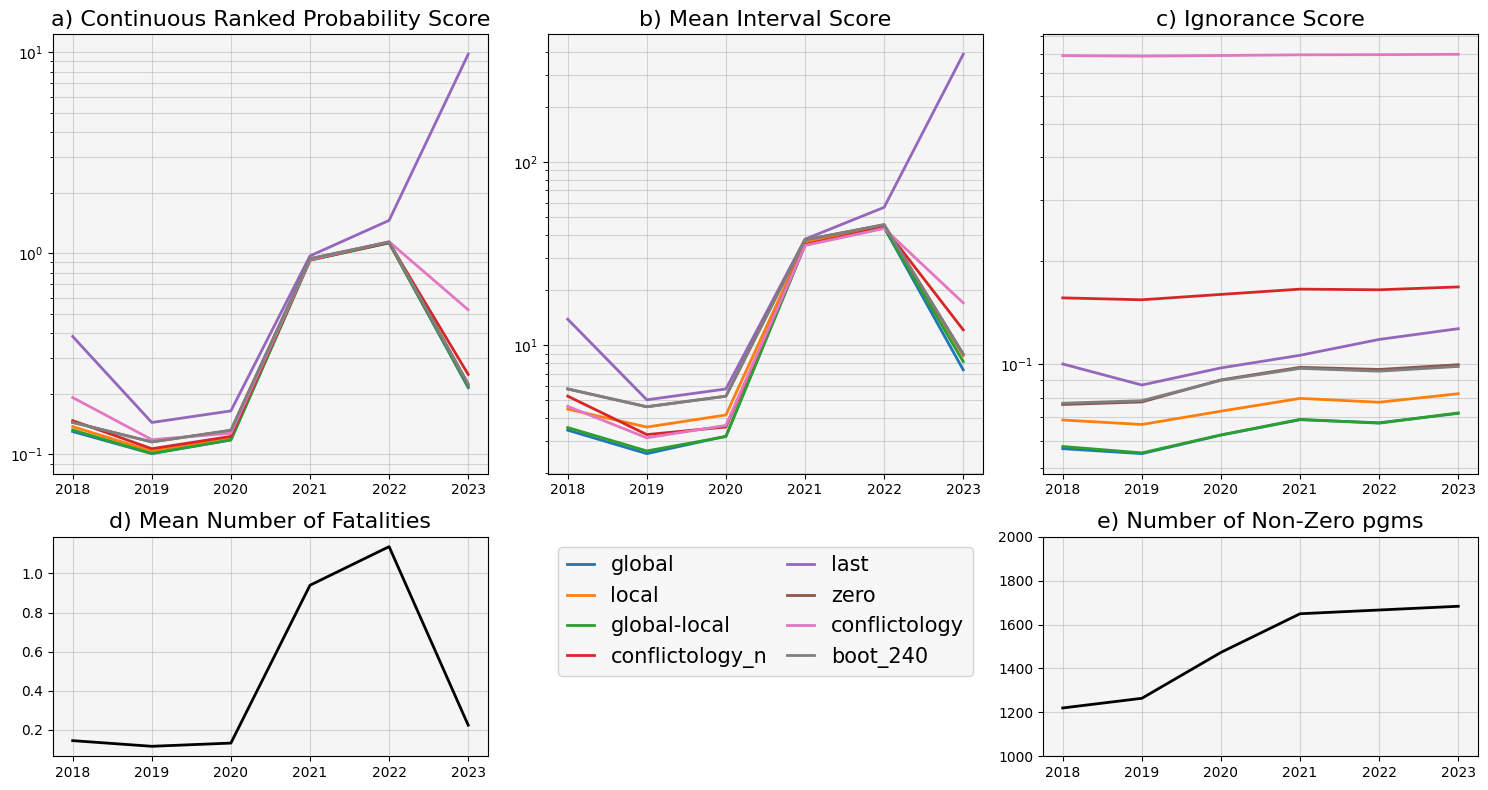

In [10]:
import matplotlib.pyplot as plt

# Uncertainty comparison
fig, axs = plt.subplots(2, 3, figsize=(15,8), gridspec_kw = {'height_ratios':[2,1]})
titles = ['a) Continuous Ranked Probability Score', 'b) Mean Interval Score', 'c) Ignorance Score', 'd) Mean Number of Fatalities',
          'e) Number of Non-Zero pgms']
metrics = ['crps', 'mis', 'ign']
models = df_metrics.columns
size = 16
# colors = ['#FECDA6', '#FF9130', '#FF5B22']
years = test_windows
for i, ax in enumerate(axs[0]):
    handles = []
    labels = []
    for j, model in enumerate(models):
        scores = df_metrics.loc[metrics[i]][model]
        line, = ax.plot(scores, linewidth=2)
        handles.append(line)
        labels.append(model)

    ax.set_yscale('log')
    ax.set_title(titles[i], size=size)


axs[1][0].plot(df_stats['mean_fat'], linewidth=2, color='black') 
axs[1][0].set_title(titles[3], size=size)

axs[1][2].plot(df_stats['dummy_count'], linewidth=2, color='black')
axs[1][2].set_ylim([1000,2000])
axs[1][2].set_title(titles[4], size=size)

for ax in axs.flatten():
    ax.set_xticks(years)
    ax.grid(which='both', alpha=.5)
    ax.set_facecolor('whitesmoke')

# legend
axs[1][1].legend(handles, labels, loc='upper center', ncols=2, fontsize=size-1, columnspacing=1, handlelength=1.3, 
                 mode='expand', facecolor='whitesmoke')
axs[1][1].axis('off')

plt.tight_layout()
plt.savefig('figures/Figure_2_metrics_correlation.png', dpi=300)
plt.show()
